In [140]:
#All import statements here
import sys
import os
import pickle
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval
import re
import matplotlib.pyplot as plt

import nltk
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import map_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('always')

# Load NLTK's English stop-words list
stop_words = set(stopwords.words('english'))

print("Loading already processed training data")
data_df = pd.read_csv("/Users/pragya/Desktop/BugClassifier/Labeled_Dataset/1880_bugs_descriptions.csv")                       #/Users/pragya/Desktop/Not All bugs are the same/dataset.csv
data_df.head(5)   
#data_df['Classification'].unique()

Loading already processed training data


,Unnamed: 0,BugId,Project,FixHashId,BUG,BIC,Comments,title,description
0,312,1242662,neutron,7d44629c2e8003f5bbb87e9b697eec54b4cce793,1,1,Exception does not exist,exceptions.Error does not exist,"def add_extension(self, ext):\n # Do no..."
1,313,1242819,nova,8c985874c7885f31871204d3f83ce547fefc5fb6,1,1,Optimize the code,Remove unnecessary steps for cold snapshots,When creating cold snapshots we first stop the...
2,314,1242933,neutron,cecd7591533e2c046aedba3b8e5d14a5b2fa7fe9,0,0,Add a feature. This allows instances to do SLA...,Security Groups does not allow RA packets in b...,"Provisioning a VM using Neutron, with RA's bei..."
3,315,1242942,cinder,5be4620ae5bb50c8436de0e11269c85a095ed40b,1,1,does not handle missing volume group gracefully,cinder does not handle missing volume group gr...,Tested with Havana rc2 from the UCA on Precise...
4,316,1242980,cinder,b104d1c0c70898b59b6668970e05cebadecd064a,1,1,NaN,volume transfer url is different from its href...,"After creating a volume transfer, I got a deta..."


In [141]:
# Adding labels based on the boolean logic
# If Bug=1 and BIC=1 -> Intrinsic
# If Bug=1 and BIC=0 -> Extrinsic
from gensim.parsing.preprocessing import remove_stopwords

def label_bool(is_bug,bic):
    if(is_bug==1 and bic==1):
        return "intrinsic"
    elif(is_bug==1 and bic==0):
        return "extrinsic"
    else:
        return "no bug"

    
def get_clean(line):

    line = line.replace("’", " ")
    line = line.replace("'", " ")
    line = line.replace("-", " ")#replace hyphens with spaces
    line = line.replace("_", " ")
    line = line.replace("/", " ")
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.replace(".", " ")
    line = re.sub("[^A-Z] ", " ", line,0,re.IGNORECASE)
    #rem_url=re.sub(r'http\S+', '',cleantext)
    #rem_num = re.sub('[0-9]+', '', rem_url)
    
    return line    

data_df['Project']=data_df['Project'].apply(lambda x: x.lower())
data_df['Project']=data_df['Project'].apply(lambda x: x.rstrip())

internal_projects=data_df['Project'].unique()

def remove_URLs(text):
    return re.sub('http://\S+|https://\S+', '', text)

def project_replace(text):
    list_text=text.split(" ")
    for i in range(len(list_text)):
        if list_text[i] in ['neutron','nova','cinder','glance','swift']:
            list_text[i]="internal project"
    return " ".join(list_text)

data_df["Classification"]=data_df.apply(lambda x: label_bool(x['BUG'],x['BIC']),axis=1)
data_df["Summary"]=data_df["description"].map(remove_URLs)
data_df["Summary"]=data_df["Summary"].map(get_clean)
data_df["Summary"]=data_df["Summary"].map(remove_stopwords)
data_df["Summary"]=data_df["Summary"].apply(lambda x: x.lower())
data_df["Summary"]=data_df["Summary"].map(project_replace)
data_df=data_df[data_df['Classification'].isin(["intrinsic","extrinsic"])]
data_df.head()

<>:37: DeprecationWarning: invalid escape sequence '\S'
<>:37: DeprecationWarning: invalid escape sequence '\S'
/var/folders/86/85pmzc355wd9gh_4rdqz5c240000gn/T/ipykernel_11421/2524697303.py:37: DeprecationWarning: invalid escape sequence '\S'
  return re.sub('http://\S+|https://\S+', '', text)


,Unnamed: 0,BugId,Project,FixHashId,BUG,BIC,Comments,title,description,Classification,Summary
0,312,1242662,neutron,7d44629c2e8003f5bbb87e9b697eec54b4cce793,1,1,Exception does not exist,exceptions.Error does not exist,"def add_extension(self, ext):\n # Do no...",intrinsic,def add extension(self ext) do extension t che...
1,313,1242819,nova,8c985874c7885f31871204d3f83ce547fefc5fb6,1,1,Optimize the code,Remove unnecessary steps for cold snapshots,When creating cold snapshots we first stop the...,intrinsic,when creating cold snapshots stop instance cre...
3,315,1242942,cinder,5be4620ae5bb50c8436de0e11269c85a095ed40b,1,1,does not handle missing volume group gracefully,cinder does not handle missing volume group gr...,Tested with Havana rc2 from the UCA on Precise...,intrinsic,tested havana rc uca precise if internal proje...
4,316,1242980,cinder,b104d1c0c70898b59b6668970e05cebadecd064a,1,1,NaN,volume transfer url is different from its href...,"After creating a volume transfer, I got a deta...",intrinsic,after creating volume transfer i got informati...
5,317,1243037,nova,01e1c027754b47239b9f9a6c40196512ec262986,1,1,Forgot to check float numbers that are not all...,parameter checking about quota update api is i...,"In this API, parameters are checked whether th...",intrinsic,in api parameters checked integer but pass flo...


In [142]:
"""data_df["Classification"] = data_df["Classification"].apply(
    lambda x: [x]
)"""
print(data_df["Classification"].values[:5])

#Splitting data using Stratified splitting function
test_split = 0.4

# Initial train and test split.
train_df, test_df = train_test_split(
    data_df,
    test_size=test_split,
    stratify=data_df["Classification"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")


['intrinsic' 'intrinsic' 'intrinsic' 'intrinsic' 'intrinsic']
Number of rows in training set: 799
Number of rows in validation set: 266
Number of rows in test set: 267


In [143]:
terms = tf.ragged.constant(train_df["Classification"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'intrinsic', 'extrinsic']


In [144]:
sample_label = train_df["Classification"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: intrinsic
Label-binarized representation: [0. 1. 0.]


In [145]:
train_df["Summary"].apply(lambda x: len(x.split(" "))).describe()

count     799.000000
mean      177.405507
std       306.050024
min         1.000000
25%        26.000000
50%        54.000000
75%       170.000000
max      2351.000000
Name: Summary, dtype: float64

In [146]:
max_seqlen = 8
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset1(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["Classification"].values)
    print(labels.shape)
    print(labels)
    label_binarized = lookup(labels).numpy()
    print(label_binarized)
    print(label_binarized.shape)
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Summary"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder


def make_dataset(dataframe,is_train=True):
    # Create a LabelEncoder instance to convert labels to numerical values
    labels = np.sort(dataframe["Classification"].unique())
    le = LabelEncoder()
    le.fit(labels)
    dataframe["Classification_encoded"] = le.transform(dataframe["Classification"])

    # Create a OneHotEncoder instance to one-hot encode the labels
    ohe = OneHotEncoder(sparse=False)
    label_binarized = ohe.fit_transform(dataframe[["Classification_encoded"]])
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Summary"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [147]:
! pip install imblearn

In [148]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

/Users/pragya/opt/anaconda3/envs/firstEnv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/pragya/opt/anaconda3/envs/firstEnv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/pragya/opt/anaconda3/envs/firstEnv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [149]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'the tempfile mktemp( function deprecated python security issues there secure alternatives available tempfile temporaryfile( there details python tempfile documentation internal project tempfile mktemp( locations profiling middleware these modified use secure method temporary file creation security hardening reasons'
Label(s): ['[UNK]']
 
Abstract: b'internal project agent l agent py log debug("not hosting snat router %" ri router id ])'
Label(s): ['intrinsic']
 
Abstract: b'ofaneutronagent init ( calls setup rpc() spawns thread consume rpcs self updated ports accessed rpc handler port update() initialized point'
Label(s): ['intrinsic']
 
Abstract: b'when creating lvm volume source volume internal project create source volume s snapshot destination volume active copy volume step self create snapshot self create volume self vg activate lv volutils copy volume but if create active target volume fail insufficient free space error example source volume s snapshot wouldn t remove

In [150]:
vocabulary = set()
train_df["Summary"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

12407


In [151]:
from transformers import AutoTokenizer, AutoModel
import torch
#tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
#model = AutoModel.from_pretrained("microsoft/codebert-base")
#data_df=data_df.map

In [152]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=4, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


In [153]:
#Oversampling using SMOTE
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
train_labels = train_dataset.map(lambda text, label: label)
#train_dataset_oversampled, train_dataset_labels = oversample.fit_resample(train_dataset, train_labels)
#print(train_dataset_oversampled)

In [154]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(528, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size()-1, activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/15
7/7 [==============================] - 1s 56ms/step - loss: 6.1226 - accuracy: 0.6608 - val_loss: 5.8097 - val_accuracy: 0.8346
Epoch 2/15
7/7 [==============================] - 0s 44ms/step - loss: 3.5338 - accuracy: 0.8411 - val_loss: 2.7967 - val_accuracy: 0.8346
Epoch 3/15
7/7 [==============================] - 0s 45ms/step - loss: 0.7480 - accuracy: 0.8598 - val_loss: 2.0525 - val_accuracy: 0.3872
Epoch 4/15
7/7 [==============================] - 0s 45ms/step - loss: 0.4606 - accuracy: 0.8385 - val_loss: 1.4391 - val_accuracy: 0.8308
Epoch 5/15
7/7 [==============================] - 0s 44ms/step - loss: 0.3607 - accuracy: 0.8886 - val_loss: 1.0199 - val_accuracy: 0.8195
Epoch 6/15
7/7 [==============================] - 0s 45ms/step - loss: 0.2283 - accuracy: 0.9537 - val_loss: 1.0967 - val_accuracy: 0.8233
Epoch 7/15
7/7 [==============================] - 0s 44ms/step - loss: 0.1616 - accuracy: 0.9687 - val_loss: 1.1603 - val_accuracy: 0.8195
Epoch 8/15
7/7 [===========

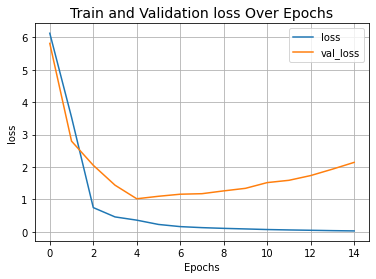

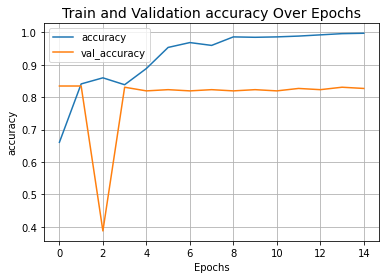

In [155]:
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

epochs = 15


#opt = keras.optimizers.Adam(learning_rate=0.02)
shallow_mlp_model = make_model()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
#tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),

# metrics"binary_accuracy"
history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs 
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
#plot_result("precision_15")
#plot_result("recall_8")
plot_result("accuracy")


In [156]:
_, acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(acc * 100, 2)}%.")

3/3 [==============================] - 0s 11ms/step - loss: 1.9252 - accuracy: 0.8614
Categorical accuracy on the test set: 86.14%.


In [157]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(64), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

predicted_classes=np.argmax(model_for_inference.predict(text_batch),axis=1) 

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Summary: {text}")
    print(f"Classification: {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Classification: ({', '.join([label for label in top_3_labels])})")
    print(" ")

2/2 [==============================] - 0s 18ms/step
Summary: b'the internal project network api currently throws error code 50 invalid input vlan field the error reproduced having following json request body "network" "admin state up" "false" "provider:segmentation id" "abc" "name" "network1" "provider:physical network" "xyz" "provider:network type" "vlan an error code 40 thrown like thrown fields correspond incorrect values'
Classification: ['intrinsic']
Predicted Classification: (intrinsic, [UNK])
 
Summary: b'internal project volume drivers netapp iscsi py internal project volume drivers netapp utils py follows raise exception invalidinput(data=msg i think following correct raise exception invalidinput(reason=msg)'
Classification: ['intrinsic']
Predicted Classification: (intrinsic, [UNK])
 
Summary: b'currently script loads metadeta definitions database uses try block open(file inside there better solution python file streams use open(file with approach sure resource cleaned code fi

/Users/pragya/opt/anaconda3/envs/firstEnv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [158]:
num_runs = 10
epochs = 9

loss_list = []
acc_list = []
val_loss_list = []
val_acc_list = []
test_acc_list = []

for i in range(num_runs):
    print(f"Training run {i+1}")
    model = make_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, verbose=0)
    loss, acc = model.evaluate(validation_dataset)
    val_loss, val_acc = history.history['val_loss'][-1], history.history['val_accuracy'][-1]
    test_loss, test_acc = model.evaluate(test_dataset)
    
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)

print(f"\nAverage validation loss: {sum(val_loss_list)/num_runs:.4f}")
print(f"Average validation accuracy: {sum(val_acc_list)/num_runs:.4f}")
print(f"Average test accuracy: {sum(test_acc_list)/num_runs:.4f}")








Training run 1
3/3 [==============================] - 0s 10ms/step - loss: 2.5943 - accuracy: 0.8202
Training run 2
3/3 [==============================] - 0s 10ms/step - loss: 2.8410 - accuracy: 0.8315
Training run 3
3/3 [==============================] - 0s 10ms/step - loss: 2.5982 - accuracy: 0.8539
Training run 4
3/3 [==============================] - 0s 10ms/step - loss: 3.8035 - accuracy: 0.8390
Training run 5
3/3 [==============================] - 0s 11ms/step - loss: 3.0058 - accuracy: 0.8127
Training run 6
3/3 [==============================] - 0s 10ms/step - loss: 2.7731 - accuracy: 0.8390
Training run 7
3/3 [==============================] - 0s 10ms/step - loss: 3.3100 - accuracy: 0.8464
Training run 8
3/3 [==============================] - 0s 10ms/step - loss: 3.9066 - accuracy: 0.8427
Training run 9
3/3 [==============================] - 0s 10ms/step - loss: 2.8542 - accuracy: 0.8315
Training run 10
3/3 [==============================] - 0s 11ms/step - loss: 2.6261 - accura

In [159]:
from sklearn.metrics import classification_report

n_classes=2
unique_labels = np.sort(data_df['Classification'].unique())

test_pred = np.argmax(shallow_mlp_model.predict(test_dataset), axis=-1)

print(test_pred)
print(test_true)
# Get the true classes of the test set
test_true = np.concatenate([y for x, y in test_dataset], axis=0)
test_true = np.argmax(test_true, axis=-1)


# Generate classification report
report = classification_report(test_true, test_pred,target_names=unique_labels)
print(report)

3/3 [==============================] - 0s 11ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 1]
[1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1

In [160]:
unique_labels = np.sort(data_df['Classification'].unique())
unique_labels

array(['extrinsic', 'intrinsic'], dtype=object)

In [161]:
### import sys
import collections

def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    lines=[s for s in lines if 'accuracy' not in s]

    # Remove empty lines
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))

    # Starts with a header, then score for each class and finally an average
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[1] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['avg'] = parse_line(avg_line)[1:]

    return data

def report_to_latex_table(data):
    avg_split = False
    out = ""
    out += "\\begin{table}\n"
    out += "\\caption{Latex Table from Classification Report}\n"
    out += "\\label{table:classification:report}\n"
    out += "\\centering\n"
    out += "\\begin{tabular}{c | c c c r}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\midrule\n"
    for cls, scores in data.items():
        if 'micro' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\end{tabular}\n"
    out += "\\end{table}"
    return out


data = parse_classification_report(report)
print(report_to_latex_table(data))

\begin{table}
\caption{Latex Table from Classification Report}
\label{table:classification:report}
\centering
\begin{tabular}{c | c c c r}
Class & Precision & Recall & F-score & Support\\
\midrule
extrinsic & 0.64 & 0.22 & 0.33 & 41\\
intrinsic & 0.87 & 0.98 & 0.92 & 226\\
macro avg & 0.76 & 0.6 & 0.63 & 267\\
avg & 0.84 & 0.86 & 0.83 & 267\\
\end{tabular}
\end{table}


<>:59: DeprecationWarning: invalid escape sequence '\m'
<>:59: DeprecationWarning: invalid escape sequence '\m'
/var/folders/86/85pmzc355wd9gh_4rdqz5c240000gn/T/ipykernel_11421/3913291006.py:59: DeprecationWarning: invalid escape sequence '\m'
  out += "\midrule\n"
